# How To Win More Games: Analyzing Rocket League Game Statistics to Improve Player Performance

## Introduction

Rocket League is a unique and fast-paced video game that involves playing soccer with cars. The objective is to hit the ball into the opponent's net while controlling a car. In Rocket League, players can do things such as flipping the car, driving on walls, increasing speed by using boost, and launching the car into the air to fly using boost.

As an experienced player who has consistently achieved the highest rank for several years, I have often wondered what I could do to win more games and propel myself to the next level. Therefore, in this project. I will analyze high level Rocket League game data provided by [Octane.gg](https://octane.gg/) and their [API](https://zsr.octane.gg/). The goal is to determine what a Rocket League player can do to increase the chances of winning a game of Rocket League. 

Rocket League offers various competitive game modes, including 1v1, 2v2, and 3v3. Since 3v3 is the main competitive mode, **this analysis will focus specifically on 3v3 games.**

### Hypothesis

In a Rocket League game, the in-game scoreboard tracks five statistics: **`score`**, **`goals`**, **`assists`**, **`saves`**, and **`shots`**. In my opinion, a higher value for each of these statistics increases the likelihood of winning the game. To investigate the significance of these statistics on winning, a logistic regression model will be used.  However, **`score`** will not be used as a predictor variable as it is dependent on the other four statistics. Having more goals, assists, saves, and shots will result in a higher score, making it redundant in the logistic regression model. While there are other ways of gaining score, e.g., touching the ball gives two points, the amount of score obtained by these alternatives is negligible compared to the score gained from the four main statistics.

In addition to examining the significance of the four key statistics, there are other statistics such as **`demos inflicted`**, **`boost stolen`**, **`shooting percentage`** that also impact gameplay. By analyzing these additional statistics, I can provide more useful tips for improving gameplay, such as how to score more goals or make more saves.

#### Null Hypotheses
An increase in goals, assists, saves, or shots while holding the other variables constant will not change the probability of winning the game.

#### Alternate Hypotheses
An increase in goals, assists, saves, or shots while holding the other variables constant will result in an increased probability of winning the game. 

- A standard significance level of 0.05 and will be used and the null hypothesis will be rejected if the p-values are less than 0.05.



### Methodology

The project will begin with extracting the statistics from Octane.gg's API and making transformations to the data. This will be followed by exploratory data analysis to identify patterns and trends within the data through visualizations. A comparison will then be made between the data of winners and losers to identify any major differences. Next, a multiple regression model will be created to test the hypotheses and predict the likelihood of winning based on a given scoreline. The findings of this analysis will be used to provide actionable tips on how to improve at Rocket League.

### Data Description

The data for this analysis will be sourced from Octane.gg's [API](https://zsr.octane.gg/). the games stored in this API are played by top-level players in top-level events, so this will provide valuable insights into the factors that affect winning at a higher skill level. The API documentation's response tab displays the [data](https://zsr.octane.gg/#games-games-get) collected from these games if we click "Show."

The data is in **JSON format**, which will be converted into a pandas dataframe. For this analysis, only statistics of the players during the game itself will be used, and not data describing the event or date, etc. These statistics are under the **`stats`** key and include **`ball`**, **`core`**, **`boost`**, **`movement`**, **`positioning`**, and **`demo`**, which all include multiple statistics under them as well. Not all of the statistics will be used. Statistics such as **`timeBoost25To50`** and **`timePowerslide`** may not have a significant impact on whether players win the game or not, therefore they will not be included in the dataset.

To extract relevant statistics that may have a significant impact on winning, a function will be created that extracts the statistics from the API response.

## Acquiring and Loading Data

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### Function to extract relevant stats from the API game data:

In [2]:
def extract_stats(games):
    data = []
    for game in games:
        team_colors = ['blue', 'orange']
        for color in team_colors:
            try:
                team_name = game[color]['team']['team']['name']
                
                player_stats = game[color]['players']
                team_data = [{
                    'team': team_name,
                    'player': player['player'].get('tag'),
                    'shots': player['stats']['core'].get('shots'),
                    'goals': player['stats']['core'].get('goals'),
                    'saves': player['stats']['core'].get('saves'),
                    'assists': player['stats']['core'].get('assists'),
                    'score': player['stats']['core'].get('score'),
                    'shooting percentage': player['stats']['core'].get('shootingPercentage'),
                    'goal participation': player['advanced'].get('goalParticipation'),
                    'boost consumed per minute': player['stats']['boost'].get('bcpm'),
                    'boost collected': player['stats']['boost'].get('amountCollected'),
                    'boost stolen': player['stats']['boost'].get('amountStolen'),
                    'time zero boost': player['stats']['boost'].get('timeZeroBoost'),
                    'time supersonic': player['stats']['movement'].get('timeSupersonicSpeed'),
                    'time defensive half': player['stats']['positioning'].get('timeDefensiveHalf'),
                    'time offensive half': player['stats']['positioning'].get('timeOffensiveHalf'),
                    'demos inflicted': player['stats']['demo'].get('inflicted'),
                    'demos taken': player['stats']['demo'].get('taken')
                } for player in player_stats]
                
                data += team_data
            except KeyError:
                continue

    return data

The function above extracts specific game statistics from the API response and appends them to a list, which will later be converted into a dataframe. The stats are self-explanatory, with the exception of a few:
- **`time supersonic`** indicates how much time a player spent at max speed. 
- "demos" in **`demos inflicted`** and **`demos taken`** refer to bumping into an opponent's car and making them explode, taking them out of play for three seconds.
- **`boost collected`** and **`boost stolen`** represent the amount of boost collected across the entire field and only in the opponent's half, respectively.

To retrieve the data, a function that makes a GET request to the API will be created. Each page stores up to 500 games, with each game represented by six rows of stats. This analysis should have at least 100,000 rows. therefore the request will go through 34 pages.

### Function to retrieve games from the API and extract their stats:

In [3]:
def list_games(filters, page_range):
    results = []
    for page in range(page_range[0], page_range[1]+1):
        filters['page'] = str(page) 
        r = requests.get("https://zsr.octane.gg/games", params=filters)
        games = r.json()['games']
        game_stats = extract_stats(games)
        results += game_stats
    return results

The function above will iterate through every page in the requested range, get the games from them, and run the extract_stats function on them. The only filter that will be used is the **`after`** filter, which will filter games after January 1st, 2022. This is because the games go back to 2016, and the skill level and meta has changed significantly since then. This way, only games from the current meta will analyzed.

Making the API request:

In [4]:
replays = list_games({'perPage': '500', 'after': '2022-01-01'}, (1, 34))

In [5]:
replays[:3]

[{'team': 'Alpha AF',
  'player': 'Madssssss.',
  'shots': 5,
  'goals': 2,
  'saves': 3,
  'assists': 0,
  'score': 631,
  'shooting percentage': 40,
  'goal participation': 50,
  'boost consumed per minute': 537.8292,
  'boost collected': 2988,
  'boost stolen': 481,
  'time zero boost': 44.7,
  'time supersonic': 86.4,
  'time defensive half': 209.94,
  'time offensive half': 138.03,
  'demos inflicted': 1,
  'demos taken': 1},
 {'team': 'Alpha AF',
  'player': 'Ronaky',
  'shots': 4,
  'goals': 2,
  'saves': 0,
  'assists': 1,
  'score': 426,
  'shooting percentage': 50,
  'goal participation': 75,
  'boost consumed per minute': 475.37048,
  'boost collected': 2641,
  'boost stolen': 840,
  'time zero boost': 40.16,
  'time supersonic': 65.35,
  'time defensive half': 193.35,
  'time offensive half': 154.35,
  'demos inflicted': 1,
  'demos taken': 1},
 {'team': 'Alpha AF',
  'player': 'matsgrey',
  'shots': 2,
  'goals': 0,
  'saves': 0,
  'assists': 3,
  'score': 403,
  'shooting

Converting the result to a pandas dataframe:

In [6]:
stats = pd.DataFrame(replays)

In [7]:
stats = stats.drop_duplicates()

In [8]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101907 entries, 0 to 101906
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   team                       101907 non-null  object 
 1   player                     101907 non-null  object 
 2   shots                      101907 non-null  int64  
 3   goals                      101907 non-null  int64  
 4   saves                      101907 non-null  int64  
 5   assists                    101907 non-null  int64  
 6   score                      101907 non-null  int64  
 7   shooting percentage        101907 non-null  float64
 8   goal participation         101907 non-null  float64
 9   boost consumed per minute  101907 non-null  float64
 10  boost collected            101907 non-null  int64  
 11  boost stolen               101907 non-null  int64  
 12  time zero boost            101907 non-null  float64
 13  time supersonic            10

There are no null values, so it is not necessary to drop or treat any rows or columns.

There is no need to delete, rearrange, or rename any columns as the columns were selected and named using the **`extract_stats()`** function.

In [9]:
stats.head(12)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken
0,Alpha AF,Madssssss.,5,2,3,0,631,40.000000,50.0,537.82920,2988,481,44.70,86.40,209.94,138.03,1,1
1,Alpha AF,Ronaky,4,2,0,1,426,50.000000,75.0,475.37048,2641,840,40.16,65.35,193.35,154.35,1,1
2,Alpha AF,matsgrey,2,0,0,3,403,0.000000,75.0,451.25098,2507,671,41.15,65.48,199.56,148.21,0,1
3,eSuba,Marcek,1,0,3,1,415,0.000000,100.0,439.19122,2440,576,52.83,60.23,230.31,120.50,2,0
4,eSuba,Gr4nk0,1,1,3,0,402,100.000000,100.0,350.45300,1947,330,57.33,37.45,257.16,90.57,0,1
5,eSuba,ToXxicko,2,0,1,0,236,0.000000,0.0,385.37228,2141,391,47.75,49.76,238.35,109.39,1,1
6,Alpha AF,matsgrey,6,1,1,1,473,16.666667,100.0,369.59870,2040,475,42.84,55.26,205.28,128.36,1,3
7,Alpha AF,Ronaky,6,1,0,1,366,16.666667,100.0,421.59613,2327,978,24.42,63.49,175.37,164.41,0,1
8,Alpha AF,Madssssss.,4,0,2,0,198,0.000000,0.0,545.52040,3011,660,63.83,87.10,163.66,176.02,1,1
9,eSuba,Gr4nk0,3,1,2,0,400,33.333333,100.0,420.32790,2320,191,52.11,48.22,252.54,87.30,1,1


The dataset is organized so that **every six rows represents a single game**. The **first three rows are the blue team**, and the **next three rows are the orange team**. The API does not provide the winner of the games, so the winner of these games will have to be assigned manually.

The dataset will be split into chunks, each containing six rows. For every chunk, the number of goals in the first three rows and the number of goals in the last three rows will be summed. The team with more goals are the winner of the match. Winners will be assigned **`1`** and losers will be assigned **`0.`**

The number of rows in the dataset must be divisible by 6, otherwise there will be an error when chunking the dataset.

In [10]:
print(len(stats) / 6)

16984.5


Deleting three rows will make the number of rows divisible by 6.

In [11]:
stats = stats.iloc[:-3]

In [12]:
print(len(stats) / 6)

16984.0


In [13]:
# Create a new column 'chunk' that assigns a unique integer to every chunk of 6 rows
stats['chunk'] = np.repeat(np.arange(len(stats)//6), 6)

# Group the stats dataframe by chunk
grouped = stats.groupby('chunk')

for chunk in grouped:
    
    # Select the second element of every chunk in grouped which contains the rows for every chunk
    chunk = chunk[1]
    
    # Calculate the number of goals for each team where team 1 is the first three rows and team 2 is the last three rows
    goals1 = chunk.iloc[:3]['goals'].sum()
    goals2 = chunk.iloc[3:]['goals'].sum()
    
    # Determine the winner of the current chunk based on which team scored more goals
    if goals1 > goals2:
        winner = 1
    else:
        winner = 0
        
    # Assign the value of 'winner' to the respective teams in the chunk, in a new column 'win'
    stats.loc[chunk.index[:3], 'win'] = winner
    stats.loc[chunk.index[3:], 'win'] = 1-winner
    
    # The last line assigns the opposite value of 'winner' from the first 3 rows to the last 3 rows in the chunk

In [14]:
stats.head(6)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,chunk,win
0,Alpha AF,Madssssss.,5,2,3,0,631,40.0,50.0,537.82920,2988,481,44.70,86.40,209.94,138.03,1,1,0,1.0
1,Alpha AF,Ronaky,4,2,0,1,426,50.0,75.0,475.37048,2641,840,40.16,65.35,193.35,154.35,1,1,0,1.0
2,Alpha AF,matsgrey,2,0,0,3,403,0.0,75.0,451.25098,2507,671,41.15,65.48,199.56,148.21,0,1,0,1.0
3,eSuba,Marcek,1,0,3,1,415,0.0,100.0,439.19122,2440,576,52.83,60.23,230.31,120.50,2,0,0,0.0
4,eSuba,Gr4nk0,1,1,3,0,402,100.0,100.0,350.45300,1947,330,57.33,37.45,257.16,90.57,0,1,0,0.0
5,eSuba,ToXxicko,2,0,1,0,236,0.0,0.0,385.37228,2141,391,47.75,49.76,238.35,109.39,1,1,0,0.0


In [15]:
stats = stats.drop('chunk', axis=1)

Saving the data as a csv (comma-seperated values) file, commonly associated with spreadsheets.

In [16]:
#stats.to_csv('C:\\Users\\Rumaan\\rl_stats.csv')

## Analysis

In [17]:
#stats = pd.read_csv("rl_stats.csv")

In [18]:
stats.head(6)

,team,player,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,win
0,Alpha AF,Madssssss.,5,2,3,0,631,40.0,50.0,537.82920,2988,481,44.70,86.40,209.94,138.03,1,1,1.0
1,Alpha AF,Ronaky,4,2,0,1,426,50.0,75.0,475.37048,2641,840,40.16,65.35,193.35,154.35,1,1,1.0
2,Alpha AF,matsgrey,2,0,0,3,403,0.0,75.0,451.25098,2507,671,41.15,65.48,199.56,148.21,0,1,1.0
3,eSuba,Marcek,1,0,3,1,415,0.0,100.0,439.19122,2440,576,52.83,60.23,230.31,120.50,2,0,0.0
4,eSuba,Gr4nk0,1,1,3,0,402,100.0,100.0,350.45300,1947,330,57.33,37.45,257.16,90.57,0,1,0.0
5,eSuba,ToXxicko,2,0,1,0,236,0.0,0.0,385.37228,2141,391,47.75,49.76,238.35,109.39,1,1,0.0


### Summary Statistics

In [19]:
stats.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,win
count,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000
mean,2.687863,0.713446,1.512698,0.551401,365.915999,24.752694,51.101653,417.596068,2444.418973,541.028664,44.086455,55.696023,234.499292,128.506137,1.043816,1.043796,0.500000
std,1.720421,0.873720,1.284247,0.754932,155.607079,31.610273,39.594820,50.637573,488.044997,227.889580,17.174232,17.654555,45.119935,31.967755,1.113260,1.057698,0.500002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.238597,12.000000,0.000000,0.000000,0.000000,19.110000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,252.000000,0.000000,0.000000,383.919035,2153.000000,379.000000,32.100000,43.700000,207.560000,107.960000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,0.000000,346.000000,0.000000,50.000000,417.382310,2377.000000,516.000000,42.190000,53.900000,228.120000,125.460000,1.000000,1.000000,0.500000
75%,4.000000,1.000000,2.000000,1.000000,457.000000,50.000000,100.000000,451.101055,2628.000000,674.000000,53.720000,65.480000,251.440000,144.520000,2.000000,2.000000,1.000000
max,15.000000,9.000000,12.000000,8.000000,1618.000000,300.000000,100.000000,686.114900,8882.000000,2533.000000,215.500000,248.940000,857.760000,535.830000,13.000000,11.000000,1.000000


There are some stats that have minimum values of zero that are highly unusual. Let's check out these rows.

In [20]:
print(stats[stats['score'] == 0])

                team    player  shots  goals  saves  assists  score  \
9803   Natus Vincere  virtuoso      0      0      0        0      0   
12794     Fox Gaming    AbuLba      0      0      0        0      0   

       shooting percentage  goal participation  boost consumed per minute  \
9803                   0.0                 0.0                   6.556382   
12794                  0.0                 0.0                   2.238597   

       boost collected  boost stolen  time zero boost  time supersonic  \
9803                36             0            26.87             0.00   
12794               12             0            92.01             0.74   

       time defensive half  time offensive half  demos inflicted  demos taken  \
9803                334.46                  0.0                0            1   
12794               104.34                 28.7                0            0   

       win  
9803   0.0  
12794  0.0  


These players have zero score but have values for other stats. This is highly unusual because you can get two score just from touching the ball. This may have resulted from players disconnecting from the game early on. For now, let's leave them in the dataset as they're only two rows out of 100,000. Removing them would be negligible.

In [21]:
print(stats[stats['time zero boost'] == 0])

                team          player  shots  goals  saves  assists  score  \
10578  Pirates Exdee          Darth.      4      0      2        1    380   
10579  Pirates Exdee          Snowyy      2      1      1        0    343   
61605          Unity  PotatoWithaGun      3      3      1        0    546   

       shooting percentage  goal participation  boost consumed per minute  \
10578                  0.0               100.0                  215.39049   
10579                 50.0               100.0                  441.36096   
61605                100.0                50.0                  303.08447   

       boost collected  boost stolen  time zero boost  time supersonic  \
10578              188             0              0.0             4.94   
10579              387            11              0.0             4.75   
61605              339            89              0.0             6.26   

       time defensive half  time offensive half  demos inflicted  demos taken  \
1057

This is unsual because they spent no time with zero boost, but they have scorelines like they were in the game playing the whole time. When going for aerials, it is common to zero out on boost when trying to reach and hit the ball. It is possible that they always stopped boosting before they hit zero boost but still very unusual as there are only three players out of 100,000 that have done this.

In [22]:
print(stats[stats['time supersonic'] == 0])

                team    player  shots  goals  saves  assists  score  \
9803   Natus Vincere  virtuoso      0      0      0        0      0   
54984     Novus Aevi      brad      0      0      2        0    129   

       shooting percentage  goal participation  boost consumed per minute  \
9803                   0.0                 0.0                   6.556382   
54984                  0.0                 0.0                  47.439045   

       boost collected  boost stolen  time zero boost  time supersonic  \
9803                36             0            26.87              0.0   
54984              274             0             9.03              0.0   

       time defensive half  time offensive half  demos inflicted  demos taken  \
9803                334.46                  0.0                0            1   
54984               358.52                  0.0                0            0   

       win  
9803   0.0  
54984  1.0  


This statistic has one of the same players with zero score, but the other player has two saves. It is possible they never hit supersonic speed the whole game, which is highly unusual. Again, removing these rows would be negligible for the analysis.

In [23]:
print(stats[stats['time offensive half'] == 0])

                team    player  shots  goals  saves  assists  score  \
9803   Natus Vincere  virtuoso      0      0      0        0      0   
54984     Novus Aevi      brad      0      0      2        0    129   

       shooting percentage  goal participation  boost consumed per minute  \
9803                   0.0                 0.0                   6.556382   
54984                  0.0                 0.0                  47.439045   

       boost collected  boost stolen  time zero boost  time supersonic  \
9803                36             0            26.87              0.0   
54984              274             0             9.03              0.0   

       time defensive half  time offensive half  demos inflicted  demos taken  \
9803                334.46                  0.0                0            1   
54984               358.52                  0.0                0            0   

       win  
9803   0.0  
54984  1.0  


This has the same two players from above.

Moving on:

On average, players have the following discrete stats:
- 2.69 shots
- 0.71 goals
- 1.51 saves
- 0.55 assists
- 1.04 demos
- 1.04 demos

For other stats, players:
- score 1 in 4 shots
- participate in 50% of all goals
- collect 2444 boost in total, with approximately 22% of that being boost stolen
- spend almost twice the time in their own half than their opponents half

The max values for some stats are:
- 15 shots
- 9 goals
- 12 saves
- 8 assists
- 1618 score
- 13 demos inflicted
- 11 demos taken
 
It is noteworthy that while these stats look incredibly difficult to achieve, it is possible because games could extend into overtime, allowing some of these stats to accumulate. It is quite obvious that the player with 857 seconds spent in the defensive half was in an overtime game, since games only last 300 seconds otherwise. Nine goals in one game is likely to be in regular time and not overtime. It is possible one team was exceptionally better than the other team, the other team gave up, or some players had disconnected.

To get a better sense of how these averages came to be, let's look at the distribution for some of these stats.

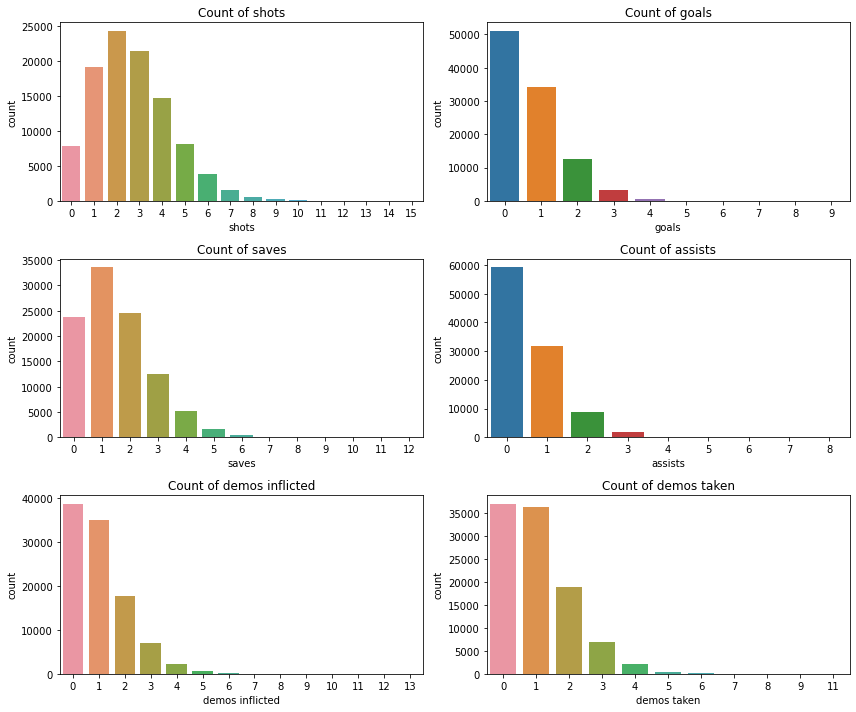

In [24]:
count_stats = ['shots', 'goals', 'saves', 'assists', 'demos inflicted', 'demos taken']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2  # Floor division results in values 0, 0, 1, 1, 2, 2
    col = i % 2   # Modulus division results in values 0, 1, 0, 1, 0, 1
                  # Together, they assign the location of the subplot on the 3x2 figure

    sns.countplot(x=stat, data=stats, ax=axs[row, col])
    axs[row, col].set_title('Count of ' + stat)

plt.tight_layout()
plt.show()


- All of these graphs are right skewed, with **`shots`** almost resembling a normal distribution.
- The most common value for **`goals`**, **`assists`**, **`demos inflicted`** and **`demos taken`** is 0.
- For **`saves`**, the most common value is 1, and for `shots` it is 2.
- It seems very rare for players to get more than 4 **`goals`** or 3 **`assists`.** 

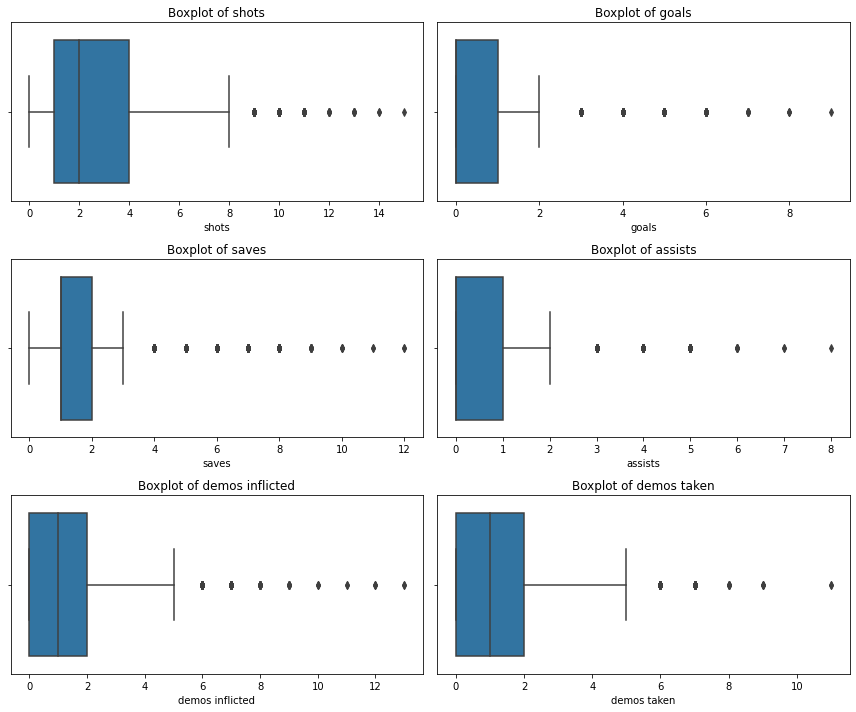

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2
    col = i % 2
    sns.boxplot(x=stat, data=stats, ax=axs[row, col])
    axs[row, col].set_title('Boxplot of ' + stat)

plt.tight_layout()
plt.show()

We can see when outliers begin to pop up for these stats.

Outliers for:
- shots: 9+
- goals: 3+
- saves: 4+
- assists: 3+
- demos inflicted: 6+
- demos taken: 6+

For really intense games, these outliers seem possible to hit, especially if the games went into overtime. If a player is performing really well, it would not be difficult for them to score three goals, have three assists, or save four shots.

### Correlation Matrix

Let's create a correlation matrix to see the relationship between all of the stats:

Text(0.5, 1.0, 'Correlation Between Rocket League Stats')

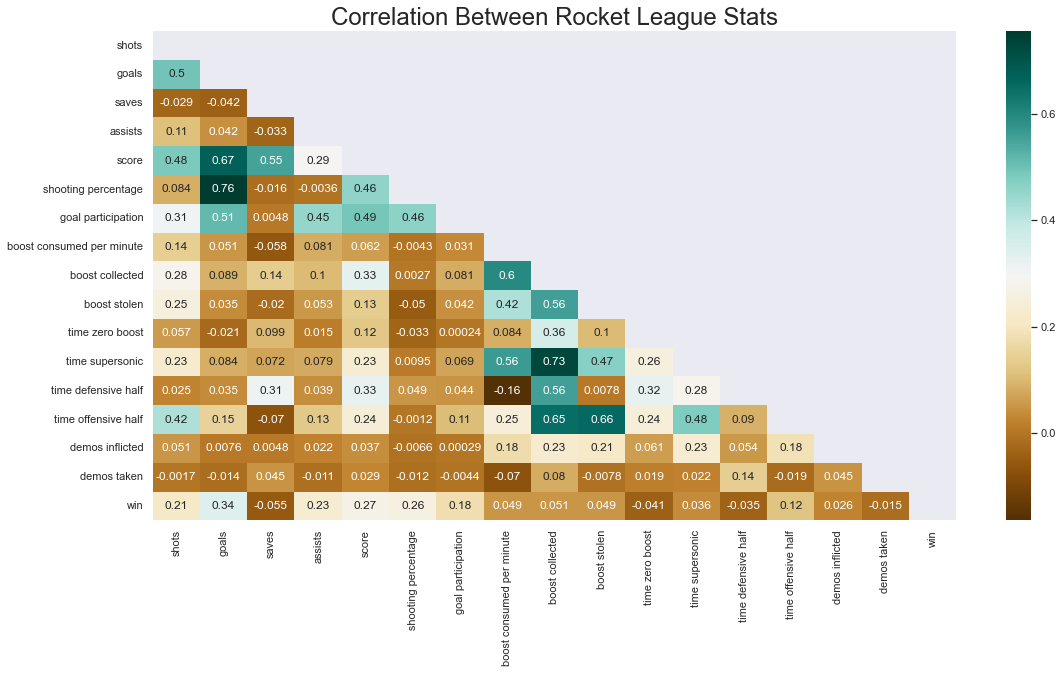

In [26]:
sns.set(rc={'figure.figsize':(18,9)})

# Create a mask that hides the upper half of the matrix to avoid redundancy and clutter
corrmask = np.triu(np.ones_like(stats.corr())) 

sns.heatmap(stats.corr(), annot=True, cmap='BrBG', mask=corrmask)
plt.title('Correlation Between Rocket League Stats', fontsize=24)

- The greatest correlation is **`shooting percentage`** vs **`goals` (0.76)** which is intuitive since the greater your shooting percentage, the more goals you will score.
- The next greatest correlation is **`time supersonic`** and **`boost collected` (0.73)**, which is also intuitive because the more boost you have, the more boost you can use to reach supersonic speed.
- An interesting correlation is **`win`** with **`saves` (-0.055)**. Although it is very weakly correlated, this implies that the more saves you have, the less of a chance you have to win the game. Another interpretation of this is that if you are already making multiple saves, the opponents likely have a lot of pressure on your net, eventually leading to goals scored against you. We can come to a similar conclusion with **`win`** and **`time defensive half` (-0.035)**, and  **`win`** and **`time offensive half` (0.12).** Spending more time in the offensive half could mean more pressure on the opponent's net, increasing the chances of scoring and winning, and decreasing the chance of shots made on your own net.
- If we look at correlations with **`win`**, the highest is **`goals` (0.34)**, followed by **`score` (0.27)**, **`shooting percentage` (0.26)**, and **`assists` (0.23)**. These are all weak to moderate correlations. It is surprising that they are not higher but they may be lower because the games are played in the 3v3 gamemode. In 3v3, there is more reliance on team play and your teammates than solo plays. This means that even if you are playing exceptionally well and end up with multiple shots/goals/assists, sometimes your teammates are not playing well and you end up losing the game anyways. I would expect these correlations to go up in 2v2's, and especially 1v1's, because there is a greater reliance on your own skill level. Only you can win the game for yourself in 1v1, so if you win, it should be reflected by your stats.
- **`demos inflicted`** has a very weak correlation with **`win` (0.026)**. It is surprising that the correlation is not higher because of the 'demo plays' that have been around in the meta recently. Things such as demoing the goalie to score on an open net which greatly increases the probability of scoring, or plays like [this](https://www.youtube.com/watch?v=B-K4LXzJpXk&ab_channel=RLMoments). Again, in 1v1's I think the correlation would be higher as there is no 2nd or 3rd player to defend when you get demoed.

### Difference Between Winners and Losers

Next, the statistics of winners and losers will be investigated to see if there are any differences in their statistics and to identify patterns or things that winners do over losers to help them win.

The dataset will be separated into two more datasets: winners and losers

In [27]:
winners = stats[stats['win'] == 1]
losers = stats[stats['win'] == 0]

Let's take a look at the distribution of stats for winners and losers:

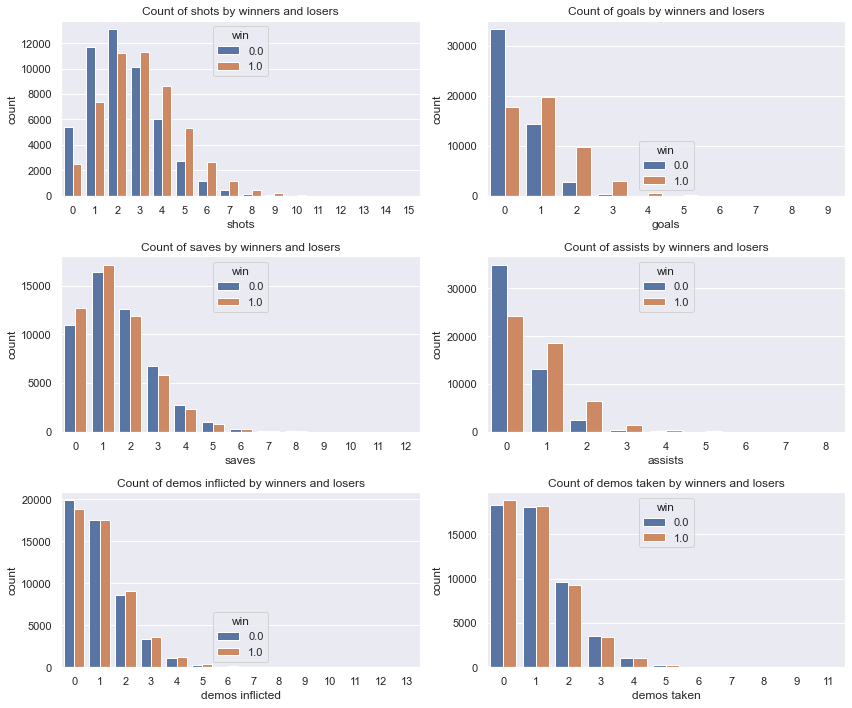

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i, stat in enumerate(count_stats):
    row = i // 2
    col = i % 2
    sns.countplot(x=stat, data=stats, ax=axs[row, col], hue='win')
    axs[row, col].set_title('Count of ' + stat + ' by winners and losers')

plt.tight_layout()
plt.show()


From the data, we can observe that there are some interesting patterns in the distribution of various statistics between winners and losers. While there is not much of a difference in the distribution of saves, demos inflicted, and demos taken, the distribution of shots, goals, and assists reveals some significant disparities.

Losers tend to shoot 0, 1, and 2 shots much more frequently than winners, while winners shoot 3 or more shots much more often. In terms of goals, 0 is still the most common value for losers, while for winners it goes up to 1. Moreover, winners tend to score more goals greater than 1 compared to losers as well. We can see the same pattern for assists.

Considering the mean goals scored of 0.71 and these graphs, if a player scores just 1 goal, they are more likely to be playing like a winner and have a better chance of winning the game.

Now let's look at summary statistics for winners and losers, and the ratio between them:

In [29]:
winners.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,win
count,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.0
mean,3.052442,1.012051,1.442652,0.723151,408.003552,32.909376,58.170185,420.098107,2469.218814,552.171024,43.384270,56.340098,232.924123,132.254726,1.072696,1.027928,1.0
std,1.770696,0.974631,1.257214,0.832557,160.271097,32.860990,33.578719,49.792872,485.724590,227.690931,16.925424,17.602178,44.513333,32.042038,1.131990,1.049194,0.0
min,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,47.439045,188.000000,0.000000,0.000000,0.000000,21.830000,0.000000,0.000000,0.000000,1.0
25%,2.000000,0.000000,1.000000,0.000000,293.000000,0.000000,33.333333,386.672995,2178.000000,389.000000,31.530000,44.350000,206.617500,111.630000,0.000000,0.000000,1.0
50%,3.000000,1.000000,1.000000,1.000000,390.000000,33.333333,60.000000,419.952045,2401.000000,529.000000,41.530000,54.510000,226.790000,129.260000,1.000000,1.000000,1.0
75%,4.000000,2.000000,2.000000,1.000000,502.000000,50.000000,100.000000,452.821215,2653.000000,685.000000,52.850000,66.070000,249.110000,148.590000,2.000000,2.000000,1.0
max,15.000000,9.000000,11.000000,8.000000,1618.000000,300.000000,100.000000,619.906250,8882.000000,2291.000000,199.250000,248.940000,762.470000,469.920000,13.000000,9.000000,1.0


In [30]:
losers.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,win
count,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.000000,50952.0
mean,2.323285,0.414841,1.582745,0.379651,323.828446,16.596012,44.033121,415.094028,2419.619132,529.886305,44.788639,55.051949,236.074462,124.757549,1.014936,1.059664,0.0
std,1.586995,0.631308,1.306986,0.622661,138.556787,28.027274,43.681457,51.347125,489.103309,227.545318,17.391324,17.683507,45.664624,31.449932,1.093458,1.065909,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.238597,12.000000,0.000000,0.230000,0.000000,19.110000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,1.000000,0.000000,222.000000,0.000000,0.000000,381.213687,2130.000000,369.000000,32.690000,43.020000,208.560000,104.650000,0.000000,0.000000,0.0
50%,2.000000,0.000000,1.000000,0.000000,304.000000,0.000000,50.000000,414.707035,2353.000000,504.000000,42.910000,53.260000,229.620000,121.870000,1.000000,1.000000,0.0
75%,3.000000,1.000000,2.000000,1.000000,403.000000,33.333333,100.000000,449.238760,2603.000000,662.000000,54.540000,64.930000,253.830000,140.200000,2.000000,2.000000,0.0
max,14.000000,5.000000,12.000000,6.000000,1500.000000,200.000000,100.000000,686.114900,8659.000000,2533.000000,215.500000,233.570000,857.760000,535.830000,10.000000,11.000000,0.0


In [31]:
# Ratio of summary statistics
winners.describe() / losers.describe()

,shots,goals,saves,assists,score,shooting percentage,goal participation,boost consumed per minute,boost collected,boost stolen,time zero boost,time supersonic,time defensive half,time offensive half,demos inflicted,demos taken,win
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
mean,1.313847,2.439608,0.911488,1.904777,1.259937,1.982969,1.321055,1.012055,1.020499,1.042056,0.968645,1.023399,0.986655,1.060094,1.056910,0.970051,inf
std,1.115754,1.543828,0.961918,1.337096,1.156718,1.172465,0.768718,0.969730,0.993092,1.000640,0.973211,0.995401,0.974788,1.018827,1.035239,0.984318,NaN
min,NaN,NaN,NaN,NaN,inf,NaN,NaN,21.191416,15.666667,NaN,0.000000,NaN,1.142334,NaN,NaN,NaN,inf
25%,2.000000,NaN,1.000000,NaN,1.319820,NaN,inf,1.014321,1.022535,1.054201,0.964515,1.030916,0.990686,1.066699,NaN,NaN,inf
50%,1.500000,inf,1.000000,inf,1.282895,inf,1.200000,1.012648,1.020399,1.049603,0.967840,1.023470,0.987675,1.060638,1.000000,1.000000,inf
75%,1.333333,2.000000,1.000000,1.000000,1.245658,1.500000,1.000000,1.007975,1.019209,1.034743,0.969014,1.017557,0.981405,1.059843,1.000000,1.000000,inf
max,1.071429,1.800000,0.916667,1.333333,1.078667,1.500000,1.000000,0.903502,1.025754,0.904461,0.924594,1.065805,0.888908,0.876995,1.300000,0.818182,inf


There seems to be a large difference between winners and losers for particular statistics.

On average, winners tend to shoot more shots, score more goals, and have more assists, resulting in a higher overall score. They also make fewer saves, inflict slightly more demos, and take slightly fewer demos. Winners collect, steal and consume slightly more boost, spend slightly more time supersonic, and slightly less time with zero boost. They also spend slight more time in the offensive half and less time in the defensive half.

The largest percentage difference is in the number of goals scored, with winners scoring on average 244% more goals than losers. The next highest differences are in shooting percentage, with a 98% increase, and assists, with a 90% increase. Additionally, winners have a 31% increase in shots and a 26% increase in score.

### Visualizing These Differences

To make it easier to see these differences, let's visualize the difference between winners and losers:

In [32]:
visual_stats = ['shots', 'goals', 'saves', 'assists', 'demos inflicted',
                'demos taken', 'score', 'shooting percentage', 'goal participation',
                'boost collected', 'boost stolen', 'boost consumed per minute',
                'time zero boost', 'time supersonic',
                'time defensive half', 'time offensive half']
means = pd.DataFrame()
means['winners'] = winners[visual_stats].mean()
means['losers'] = losers[visual_stats].mean()
means

,winners,losers
shots,3.052442,2.323285
goals,1.012051,0.414841
saves,1.442652,1.582745
assists,0.723151,0.379651
demos inflicted,1.072696,1.014936
demos taken,1.027928,1.059664
score,408.003552,323.828446
shooting percentage,32.909376,16.596012
goal participation,58.170185,44.033121
boost collected,2469.218814,2419.619132


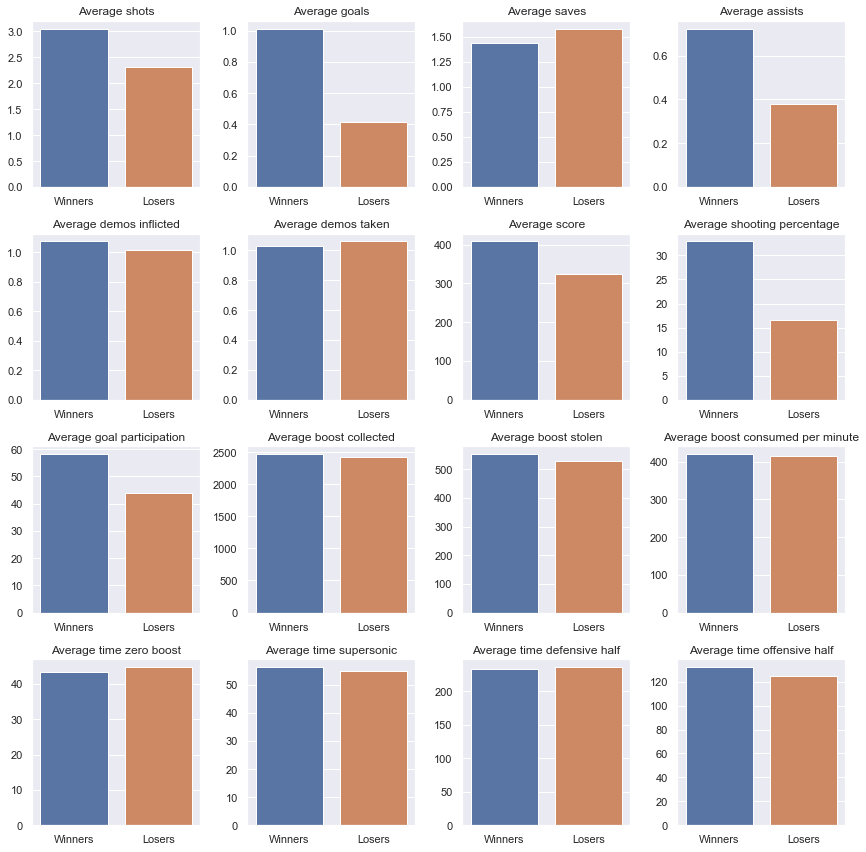

In [33]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

for i, stat in enumerate(visual_stats):
    
    ax = axs[i // 4, i % 4]
    sns.barplot(x=['Winners', 'Losers'],
                y=[means['winners'][i], means['losers'][i]],
                ax=ax)
    ax.set_title('Average ' + stat)
    
plt.tight_layout()
plt.show()


These graphs make it easier to see the differences between winners and losers for the stats. The **biggest differences** we can see come from **`goals`, `assists`, `shots`, `shooting percentage`, `goal participation`, and `score`.** We can see a slight difference in **`saves` and `time offensive half`**, and the rest of the stats look very similar between winners and losers. 


In the conclusion, tips to help play more like a winner will be discussed. For now, let's move on to the statistical analysis portion.

## Logistic Regression

Logistic regression can be used to predict whether a player will win the game or not. **`win`** will be the dependent, binary variable, and **`goals`**, **`assists`**, **`saves`**, and **`shots`** will be the predictor variables. 

Before we begin, let's look for extreme outliers (greater than outer fence values) in these four predictor variables:

In [34]:
stats_list = ['goals', 'assists', 'saves', 'shots']

for stat in stats_list:
    IQR = stats[stat].quantile(0.75) - stats[stat].quantile(0.25)
    Lower_fence = stats[stat].quantile(0.25) - (IQR * 3)  # (IQR * 1.5) if we were looking for greater than inner fence values
    Upper_fence = stats[stat].quantile(0.75) + (IQR * 3)
    print('extreme outliers for {s} are values < {lowerboundary} or > {upperboundary}'
          .format(s=stat, lowerboundary=Lower_fence, upperboundary=Upper_fence))
    print('max number of {s} is {m}'.format(s=stat, m=stats[stat].max()))
    print('mean number of {s} is {m}'.format(s=stat, m=stats[stat].mean()))
    print('')


extreme outliers for goals are values < -3.0 or > 4.0
max number of goals is 9
mean number of goals is 0.7134459883812215

extreme outliers for assists are values < -3.0 or > 4.0
max number of assists is 8
mean number of assists is 0.5514013188883655

extreme outliers for saves are values < -2.0 or > 5.0
max number of saves is 12
mean number of saves is 1.5126982257811272

extreme outliers for shots are values < -8.0 or > 13.0
max number of shots is 15
mean number of shots is 2.6878630868268174



#### Dealing with outliers from dataset

The maximum values for each statistic appear to be extremely high, but not impossible to reach. It is possible for a player to have an exceptional performance, or for their team to be significantly better than their opponent. These factors could contribute to the high maximum values for these statistics.

However, these extreme values do not seem to be errors in data collection. Instead of removing them, we can cap the values at the upper limit before running the logistic regression. This allows us to keep the valuable information provided by these statistics while preventing them from overly influencing the model.

In [35]:
data = stats.filter(['team', 'player', 'goals', 'assists', 'saves', 'shots', 'win'])

In [36]:
data['goals'] = data['goals'].clip(upper=4)

data['assists'] = data['assists'].clip(upper=4)

data['saves'] = data['saves'].clip(upper=5)

data['shots'] = data['shots'].clip(upper=13)

data.describe()

,goals,assists,saves,shots,win
count,101904.000000,101904.000000,101904.000000,101904.000000,101904.000000
mean,0.711228,0.550793,1.502228,2.687824,0.500000
std,0.863143,0.751494,1.247454,1.720169,0.500002
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,2.000000,0.500000
75%,1.000000,1.000000,2.000000,4.000000,1.000000
max,4.000000,4.000000,5.000000,13.000000,1.000000


#### Checking for multicollinearity

One assumption for logistic regression is little to no multicollinearity among the predictor variables. That means there is not a high level of correlation between them. One way to check is through the correlation matrix created above. Another method is calculating the variance inflating factor (VIF), which measures how much the variance of the estimated regression coefficient is increased due to multicollinearity. A VIF greater than 5 means the variable is highly correlated to another variable in the model and is usually unacceptable to use in a regression model.

#### Calculating VIF

In [37]:
model_stats = data[['goals', 'assists', 'saves', 'shots']]

model_stats = sm.add_constant(model_stats)

vif = pd.DataFrame()
vif['feature'] = model_stats.columns
vif['vif'] = [variance_inflation_factor(model_stats.values, i)
                           for i in range(len(model_stats.columns))]
print(vif)

   feature       vif
0    const  5.394434
1    goals  1.324358
2  assists  1.013489
3    saves  1.002891
4    shots  1.337408


The VIF values for all of the features are **less than 1.5**, which is a great sign. None of the independent variables are highly correlated to each other.

#### Splitting and training the data

In [38]:
X = data[['goals', 'assists', 'saves', 'shots']]
y = data['win']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=123)

#### Creating the model

In [39]:
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.601287
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                76428
Model:                          Logit   Df Residuals:                    76423
Method:                           MLE   Df Model:                            4
Date:                Sat, 18 Feb 2023   Pseudo R-squ.:                  0.1325
Time:                        22:25:41   Log-Likelihood:                -45955.
converged:                       True   LL-Null:                       -52976.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0191      0.019    -54.112      0.000      -1.056      -0.982
goals          0.9310      0.

The p-value for each predictor variable is less than **`0.05`**, indicating each variable is statistically significant and has an impact on the probability of winning the game. Therefore, we can **reject the null hypothesis.**

#### Predictions and evaluations of the model

In [40]:
pred = result.predict(X_test)
prediction = list(map(round, pred))

#### Test Accuracy

In [41]:
print('Test accuracy = ', accuracy_score(y_test, prediction))

Test accuracy =  0.6800518134715026


#### Confusion Matrix

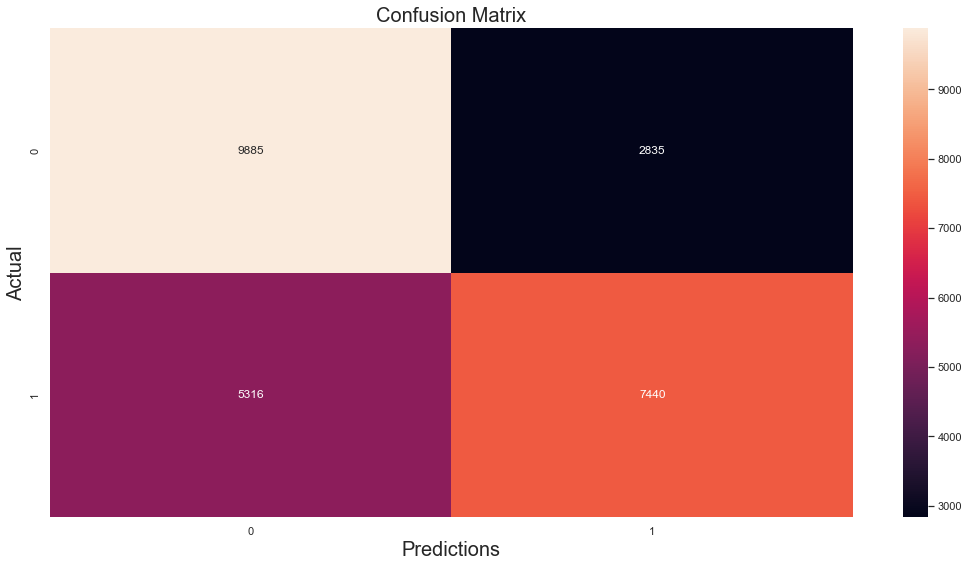

In [42]:
cm = confusion_matrix(y_test, prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

There are 9885 + 7440 = **17325 correct predictions** and 2835 + 5316 = **8151 incorrect predictions**.

#### Adding each player's probability of winning the game to the dataset

In [43]:
predictions = []
for index, row in data.iterrows():
    scoreline = [row['goals'], row['assists'], row['saves'], row['shots']]
    predict_data = {'const': 1, 'goals': scoreline[0], 'assists': scoreline[1],
                    'saves': scoreline[2], 'shots': scoreline[3]}
    predict_data = pd.DataFrame(data=predict_data, index = [0])
    prediction = result.predict(predict_data)
    predictions.append(prediction[0])

In [44]:
data['probability of winning'] = predictions
data['probability of winning'] = round(data['probability of winning'], 2)

In [45]:
data.head(6)

,team,player,goals,assists,saves,shots,win,probability of winning
0,Alpha AF,Madssssss.,2,0,3,5,1.0,0.71
1,Alpha AF,Ronaky,2,1,0,4,1.0,0.85
2,Alpha AF,matsgrey,0,3,0,2,1.0,0.76
3,eSuba,Marcek,0,1,3,1,0.0,0.39
4,eSuba,Gr4nk0,1,0,3,1,0.0,0.44
5,eSuba,ToXxicko,0,0,1,2,0.0,0.27


Based on the first game in the dataset, the probabilities of each player winning the match seem to be accurate. The winners each with their scoreline all had > 71% chance to win, and losers < 44% chance to win.

#### Unlucky vs Lucky Players

In [46]:
print(data[(data['goals'] > 3)
         & (data['win'] == 0)].head())

                  team  player  goals  assists  saves  shots  win  \
9057           NO FEAR  Blazer      4        0      2      5  0.0   
22467    Guild Esports     crr      4        0      3      7  0.0   
22815        00 Nation   hibbs      4        0      0      3  0.0   
30873  You're Throwing    SQQP      4        1      1      6  0.0   
31527        Team Rise    Hexa      4        1      1      4  0.0   

       probability of winning  
9057                     0.94  
22467                    0.94  
22815                    0.94  
30873                    0.97  
31527                    0.97  


In [47]:
print('maximum probability of winning : {max}'.format(max = data['probability of winning'].max()))
print('number of games where the probability of winning is more than or equal to 0.7 and players lose: {number}'
      .format(number = len(data[(data['probability of winning'] >= 0.7)
                        & (data['win'] == 0)])))

maximum probability of winning : 1.0
number of games where the probability of winning is more than or equal to 0.7 and players lose: 3831


In [48]:
print(data[(data['goals'] == 0) 
         & (data['saves'] == 0) 
         & (data['assists'] == 0)
         & (data['shots'] == 0)
         & (data['win'] == 1)].head())

                   team  player  goals  assists  saves  shots  win  \
392        Violencia V2  LuiisP      0        0      0      0  1.0   
875           Nightmare   qNa9r      0        0      0      0  1.0   
959          Mad Titans  moayad      0        0      0      0  1.0   
1073  Clovarity Esports    Joyy      0        0      0      0  1.0   
1328                NSF  Kaizen      0        0      0      0  1.0   

      probability of winning  
392                     0.27  
875                     0.27  
959                     0.27  
1073                    0.27  
1328                    0.27  


In [49]:
print('minimum probability of winning : {min}'.format(min = data['probability of winning'].min()))
print('number of games where the probability of winning is less than or equal to 0.3 and players win: {number}'
      .format(number = len(data[(data['probability of winning'] <= 0.3)
                        & (data['win'] == 1)])))

minimum probability of winning : 0.21
number of games where the probability of winning is less than or equal to 0.3 and players win: 7489


## Conclusion

### Model

- The analysis found that the variables `goals`, `assists`, `saves`, and `shots` all have a significant impact on the probability of winning a Rocket League game, with a p-value of less than 0.05.
    - Therefore, we can reject the null hypothesis.
    
    
- The regression coefficients for the variables are as follows, in order of highest to lowest impact on the probability of winning a game:  **goals (0.9310)**, **assists (0.6945)**, **saves (-0.0586)**, and **shots (0.0415).**
    - Goals and assists have a large impact on the probability of winning a game, while saves and shots have a small impact
    - While the rest of the variables increase the probability of winning, saves decrease the probability of winning, which goes against the alternate hypothesis
    
    
- The model has an accuracy of **68%**. While 68% is not particularly high, it is still a reasonable level of predictive power for predicting the winner of Rocket League games, solely on the scoreboard. If two-thirds of all Rocket League matches can be accurately assessed by only looking at the scoreboard, that is satisfactory for the purpose of this analysis. 
    - We can see the variability in these games and one reason the model has trouble predicting more games correctly. In the **"Unlucky vs Lucky Player"** section, we can see that even if players play exceptionally well with a scoreline (goals, assists, saves, shots) of **`4,1,1,6`** they still lose. We can see the opposite as well where players seem to play very poorly with a scoreline of **`0,0,0,0`** but still win.
    - According to this model, there are **7489 players** who had less than a **30%** chance of winning but **won**, and **3831 players** who had over a **70%** chance of winning but **lost**.
    - The most reasonable explanation of this would be because these are **3v3 games**. Individual performance is not the sole determinant of the outcome of the match. If you play amazingly but your teammates do not perform well, you can still lose the game. If you play really poorly, there is a chance either one of both of your teammates are playing well enough to carry you to a win.
    - In contrast, scoring 0 goals in a 1v1 game would result in a loss no matter what.

### Suggestions

- This analysis kept it simple and only used the in-game scoreboard stats as predictor variables. Future projects could incorporate more predictor variables into the model such as demo and boost statistics to see if they increase the accuracy of the model.
- Future projects could look into creating models and analyzing 2v2 or 1v1 game data. I hypothesize that the correlations between statistics and predictive power of the model would go up because those modes are less reliant on teammates and team play. There would be less variabilty due to teammates performances.
- Future projects could look into aggregating the statistics of all players on the team, to determine how well the team as a whole must play in order to win.
- These games were played in high level events. Future projects could analyze data from the in-game ranked game modes, and even compare the differences between ranks.
- To account for extreme values in statistics due to overtime, only analyze data from games where overtime did not take place.

### How to play like a winner

- Now that we know the key factors that contribute to winning a game of Rocket League, we can list some tips for improving gameplay and increasing your chances of winning. These tips come from an experienced player and are reasoned from statistics.

    - **Shots and goals:**
        - You are already playing like a winner if you score just one goal. 
        - The largest correlation was between shooting percentage and goals. Scoring goals increases the chance of winning the most, so you want to train your precision and accuracy to be able to score more goals. Doing training packs repetitively everyday to help train your muscle memory will help you shoot better shots and score more goals.
        - When shooting at the net, do not just aim randomly. Look at the defender's position and try to make it as hard as possible for them to save your shot. If they are coming in from the bottom right, try to aim for the top left corner. This is particularly important at higher levels of play as defence can get really [impressive](https://www.youtube.com/shorts/1bHWqlBGRUI). Making decisions on where to shoot the ball based on the positions of the defenders can significantly improve your chances of scoring and winning the game.
        
    - **Assists:**
        - Assists is the next greatest predictor of winning a game.
        - To maximize your chances at success, you must be aware of the positions of your teammates at all times. You do not want to make a pass to a teammate that you thought was there but is not. That gives away possession and pressure.
        - Do not be selfish, and do not try to be a hero. If you see your teammate has a better angle to shoot the ball, try to pass the ball to them instead of going for a solo play. If you and your teammate are both going for a shot, back off and let them shoot if they have a better chance of scoring.
        - You can also increase the chance of your teammate getting an assist by being in the right position at the right time. If you see your teammate going up the field with the ball, try to position yourself where you can receive the ball and take a shot, if they do pass the ball to you.
                
    - **Saves:**
        - The more saves you make, the lower your probability of winning the game is. That does not mean you should not go for saves. You still have to make necessary saves if you want to win the game, but the key is preventing these situations from happening in the first place. 
        - Winners spend more time in the offensive half than defensive half. This likely means there is more pressure on the opponent's net than their own net. You cannot make saves if the pressure is all on the opponent. This does not mean if the ball comes to your half, you clear it back to the opponent without thinking and give away possession again. See if there are any ways you can keep possession. Pass the ball to a teammate up the field, or dribble it up the field and try to beat at least one defender by flicking it past them.
        - If you do find yourself in a situation where you need to make a save, which you inevitably will be in, learn specific mechanics such as the [half-flip](https://www.youtube.com/shorts/ZfYU86N7dBU) to improve your defence. In the short video, they go over how you can use a half-flip to get back to your own half faster if you are out of position and need to make the save. In general the half-flip is a must-know mechanic to help you move around the field better.
        - If you're rotating in to be the goalie, try to position yourself at the backpost. That means positioning yourself on the post of your net that is opposite to the side where the ball is. One of your teammates might be at the frontpost and expect you to rotate into backpost. Also, it is easier to make a save on the whole net when you can go forward, but if you are frontpost and the opponent shoots the ball behind you, it is a lot harder to make the save.
                
    - **Demos:**
        - Winners and losers have very similar statistics regarding demos. 
        - You should go for demos if the situation is right. For example, if you are in a 2 on 1 situation,  go for a demo on the goalie to make it a free shot for your teammate. If you are defending and one of the opponents is in a position to receive a pass to take a shot, demo them before they can take the shot.
        - You should not only be aware of your teammates positions. You should also be aware of the opponents position at all times. If you are the goalie and you see an enemy coming to demo you, try to dodge by jumping over them or flipping to the side. If you are on the attack and an opponent is behind you, there is a good chance they are going to try to demo you. Try to anticipate them demoing you and time your jump accordingly to dodge the demo.
                
    - **Boost:**
        - Winners collect and steal more boost, spend more time supersonic and less time with 0 boost.
        - Often times, players seem to only go for the big pad boosts which give max boost instead of going for a few small pad boosts which give 12 each. Going for the smaller pads to keep your boost up is a great way to always have boost and be ready to make a shot or save.
        - It is common for players to go all the way back to their own side of the field to grab the big pad to refuel when their team has all the pressure on the opponents. This is not good because you risk losing all the pressure if the opponents make a clear. Instead, players should control the midfield big boosts, and collect the small and big boosts on the opponents side to keep up the pressure. This also takes boost away from the opponents making it harder for them to make a save.
        - You can reach supersonic speed without using boost, which is a good way to save boost for important situations. Instead of using boost to speed up, you can use a little bit of boost and flip forwards which gives you momentum and speed. 
        - If you are supersonic and want to switch directions, making a sharp turn will make you lose momentum. If you make a more rounded turn, you will stay supersonic. Doing diagonal flips is also a good way to keep speed and change directions.
        - Staying supersonic is really helpful as it can help you get to the right position faster, especially in the offensive half. It also a requirement to be able to demo someone, so you if are supersonic for longer, you could potentially make more demo plays.